In [1]:
import sys
import os
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF

import statsmodels.api as sm
import scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_91507/1135055814.py:17: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'
temp_filtered_path = 'temp_filtered_data/'

In [3]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random

# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

In [4]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)
    #return butter(order, cutoff, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)
    #return butter(order, cutoff, btype='low', analog=False)
    
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
flux_ts = time_series(flux)
flux_clean_ts = time_series(flux_clean)

In [12]:
# Filter requirements.
order = 5
fs = 1.0       # sample rate, Hz
cutoff = 1/12  # desired cutoff frequency of the filter, Hz

In [ ]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [ ]:
# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=1024)

plt.figure(figsize=(20,8))
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [13]:
T = 1500.0         # months
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)

In [ ]:
%%time
y = flux_clean.shape[1]
x = flux_clean.shape[2]

flux_clean_filtered = np.empty((flux_clean.shape[0],y,x))

for i in range(y):
    for j in range(x):
        fl_filt = butter_lowpass_filter(flux_clean[:,i,j], cutoff, fs, order)
        flux_clean_filtered[:,i,j] = fl_filt
    print("filtered at {},{}".format(i,j))

In [ ]:
flux_clean_filtered = xr.DataArray(flux_clean_filtered,
                                   dims=flux_clean.dims,
                                   coords=flux_clean.coords,
                                   attrs=flux_clean.attrs)

flux_clean_filtered.to_netcdf(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+temp_filtered_path+"flux_clean_filtered_12mon.nc")

In [6]:
flux_clean_filtered = xr.open_dataset(inDirName+interim_data_folder+
                                      cise_file_path+std_file_path+temp_filtered_path+"flux_clean_filtered_12mon.nc")

flux_clean_filtered = flux_clean_filtered.__xarray_dataarray_variable__
flux_clean_filtered_ts = time_series(flux_clean_filtered)

In [ ]:
# Plot both the original and filtered signals.

spinuptime = 300 
plt.figure(figsize=(20,8))
plt.plot(t,flux_ts[spinuptime:], 'b-',lw=0.5, label='Original Data')
plt.plot(t,flux_clean_ts, 'r-',lw=0.5, label='Cleaned data')
plt.plot(t,flux_clean_filtered_ts, 'g-',lw=1.5, label='Cleaned and Filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
#f, Px = signal.welch(flux_clean_ts,fs=2.0)
#plt.plot(f,10*np.log10(Px))
#plt.psd(flux_clean_ts);

#plt.figure(figsize=(15,6))
plt.psd(flux_ts,noverlap=120, NFFT=256,label='Original Data');
plt.psd(flux_clean_ts,noverlap=120,NFFT=256,label='Cleaned Data');
plt.psd(flux_clean_filtered_ts,noverlap=120,NFFT=256,label='Cleaned and Filtered Data');
plt.legend();

In [ ]:

#plt.figure(figsize=(12,8))
plt.subplots(1,3,figsize=(22,8))
plt.suptitle('Spectrograms')

specvmin=-100
specvmax=-20
fs_spec = 1.0

spinuptime = 300 # 25 year period assumed model spinup for flux_ts (original data)

plt.subplot(131)
plt.specgram(flux_ts[spinuptime:],Fs=fs_spec,vmax=specvmax,vmin=specvmin);
#plt.colorbar()
plt.xlabel("Time (months)")
plt.ylabel("Frequency (Hz)")
plt.title('Original Data')

plt.subplot(132)
plt.specgram(flux_clean_ts,Fs=fs_spec,vmax=specvmax,vmin=specvmin);
#plt.colorbar()
plt.xlabel("Time (months)")
plt.title('Cleaned Data')

plt.subplot(133)
plt.specgram(flux_clean_filtered_ts,Fs=fs_spec,vmax=specvmax,vmin=specvmin);
cbar = plt.colorbar()
plt.xlabel("Time (months)")
plt.title('Cleaned & Filtered Data')

cbar.ax.set_ylabel('Power (dB/Hz)');

In [ ]:
flux_clean_tmean = flux_clean_filtered.mean('time')
flux_clean_tstd = flux_clean_filtered.std('time')

flux_clean_demeaned = flux_clean_filtered - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [ ]:
flux_clean_demeaned_ts = time_series(flux_clean_demeaned)

In [ ]:
# Plot both the original and filtered signals.

spinuptime = 300 
plt.figure(figsize=(20,8))
plt.plot(t,flux_clean_filtered_ts, 'g-',lw=1.5, label='Cleaned and Filtered data')
plt.plot(t,flux_clean_demeaned_ts, 'k-',lw=1.5, label='Cleaned and Filtered and Demeaned data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [ ]:
%%time
model = EOF(flux_clean_normalized) # change accordingly if using original data, or normalized data
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)
eofs_eig = model.eofs(1)
eofs_sng = model.eofs(2)

In [ ]:
# Figure: Relative power of m EOFs
m = 250
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='black')
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {:.2f}%'.format(m, varexpl[:m].sum().values*100));

In [ ]:
nmodes_plot = 3 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs_eig.sel(mode=i+1).plot(ax=a0,
                                cmap='cmo.balance',
                                add_colorbar=True,
                                cbar_kwargs={'orientation': 'vertical',
                                             'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs_eig.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 2
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        #random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

In [ ]:
nmodes_plot = 4 # Number of modes to plot
nrealizations_to_plot = 2 # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(25,20))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.5)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.5)
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', noverlap=120,NFFT=256,linewidth=0.25,label='Randomized')
    a0.plot(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a1.psd(pcs[:,i],color='k', noverlap=120,NFFT=256,linewidth=2.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

In [23]:
def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [29]:
flux_clean_reconstr_noise = xr.open_dataset(inDirName+interim_data_folder+
                                            cise_file_path+std_file_path+temp_filtered_path+"flux_clean_reconstr_noise_12mon.nc")

flux_clean_reconstr_noise = flux_clean_reconstr_noise.__xarray_dataarray_variable__

In [32]:
flux_clean_reconstr_noise_ts = time_series(flux_clean_reconstr_noise)

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(2):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr = flux_reconstr + flux_clean_reconstr_noise
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+temp_filtered_path+"REC_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

In [7]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+temp_filtered_path+'REC_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+temp_filtered_path+'REC_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

In [8]:
flux_reconstr0_ts = time_series(flux_reconstr0)
flux_reconstr1_ts = time_series(flux_reconstr1)

In [9]:
catchments = np.array([1,27,28,61,70,83,94,71,22])
basins = catchments+33

In [24]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    #orig = clip_data(flux_clean_filtered, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    orig.rename('orig'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"orig_{}_1500modes_12mon.nc".format(basin))
    rec0.rename('rec0'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"rec0_{}_1500modes_12mon.nc".format(basin))
    rec1.rename('rec1'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"rec1_{}_1500modes_12mon.nc".format(basin))
    del orig, rec0, rec1
    gc.collect()

In [25]:
for basin in basins:
    basin_combined_datasets = xr.open_mfdataset(inDirName+interim_data_folder+
                                                cise_file_path+std_file_path+temp_filtered_path+"*{}_1500modes_12mon.nc".format(basin),
                                                combine="nested")
    basin_combined_datasets.to_netcdf(inDirName+interim_data_folder+
                                      cise_file_path+std_file_path+temp_filtered_path+"combined_{}_1500modes_12mon.nc".format(basin))
    del basin_combined_datasets
    gc.collect()

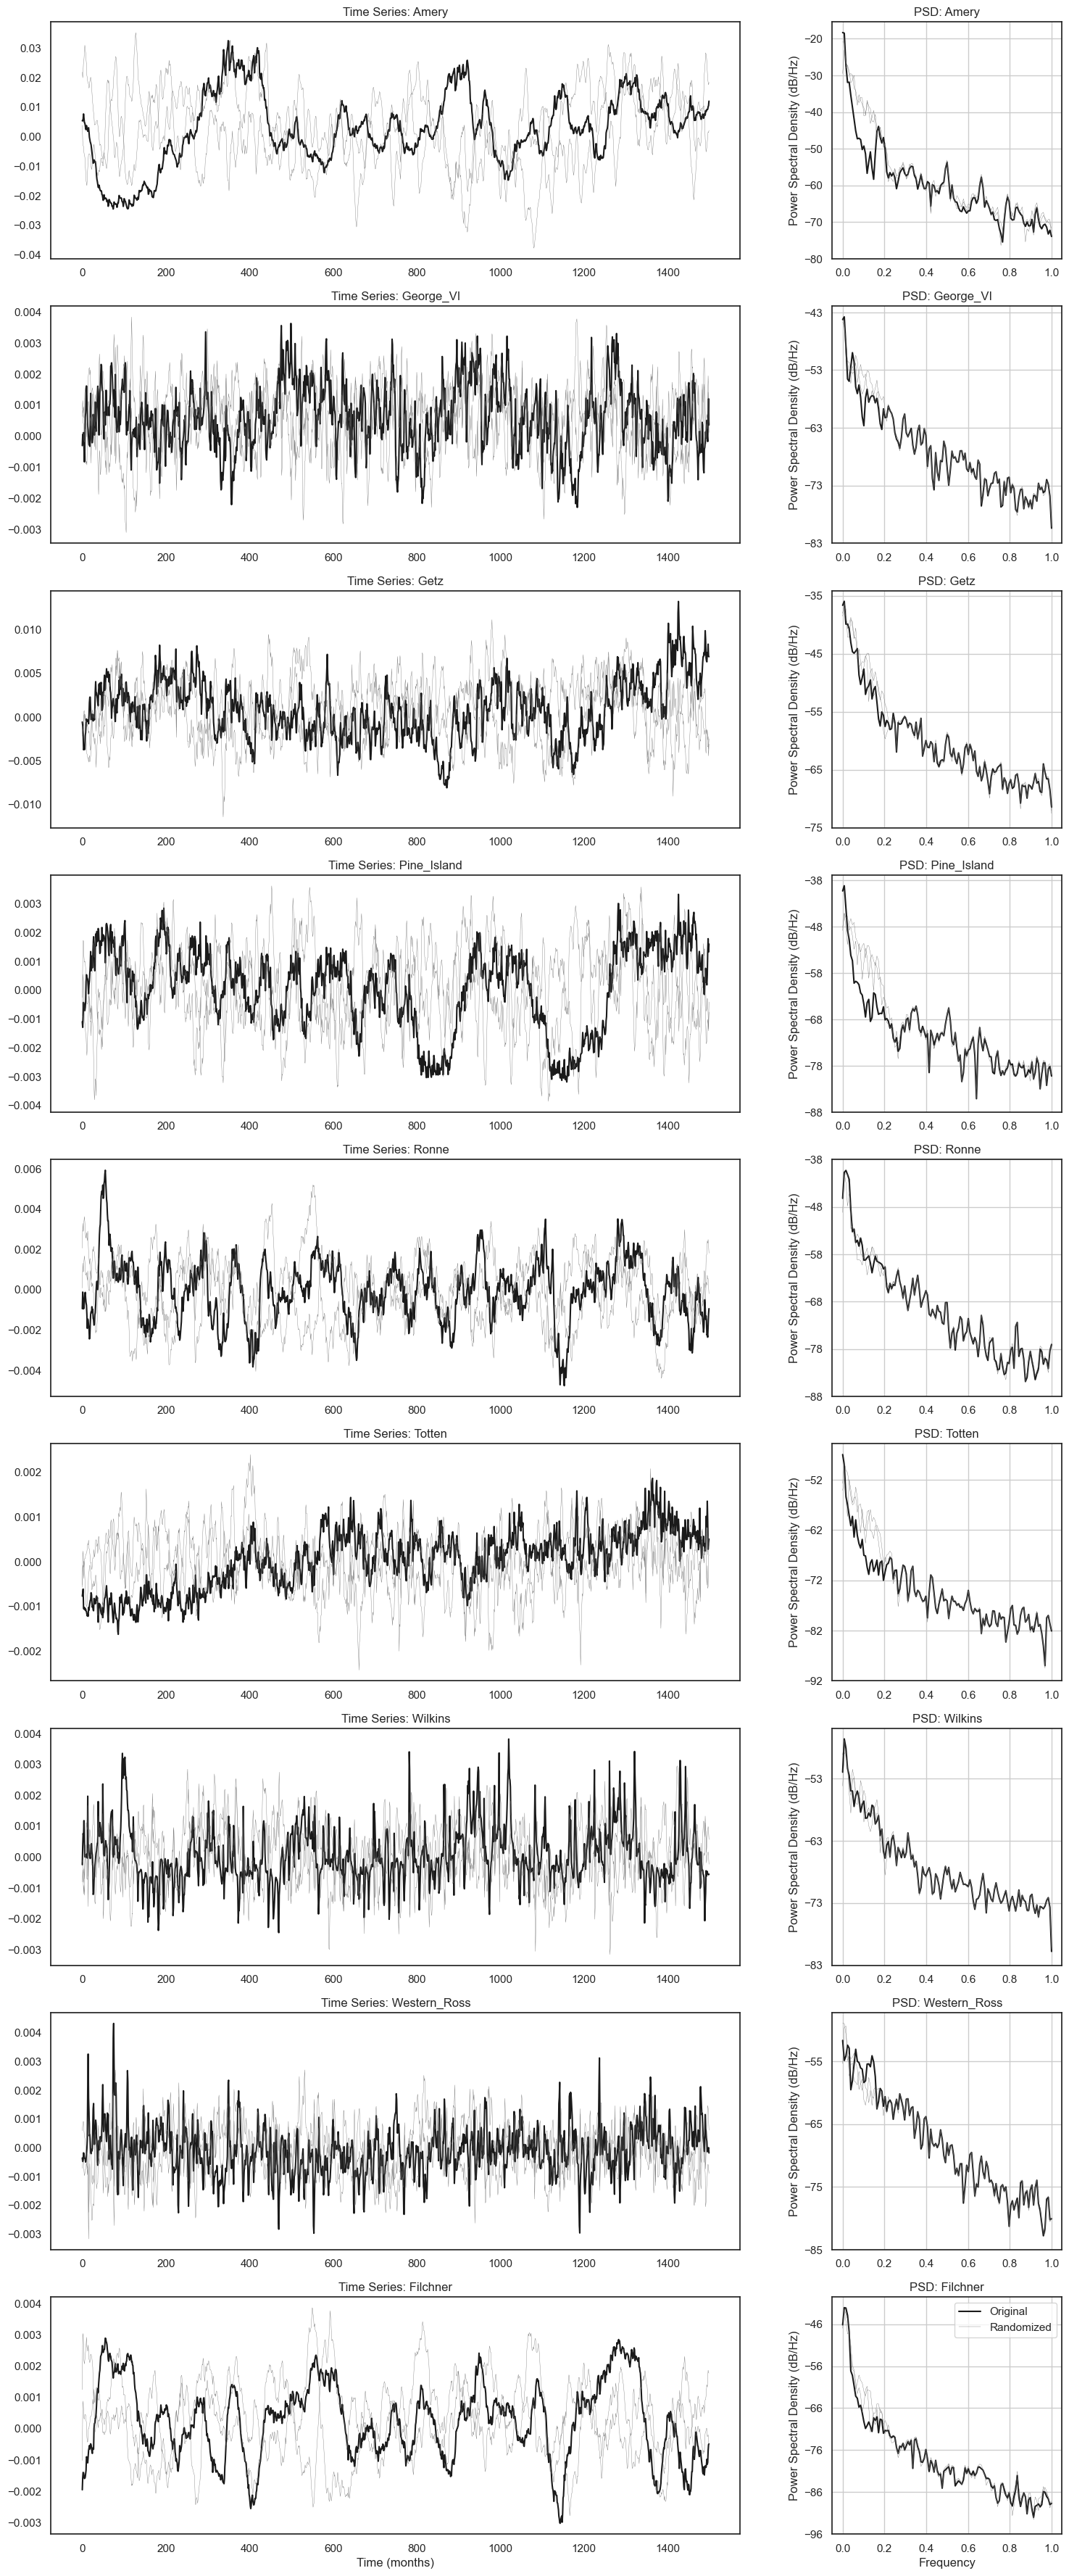

In [26]:
n_basins = len(basins)

color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    combined_ds = xr.open_dataset(inDirName+interim_data_folder+
                                  cise_file_path+std_file_path+temp_filtered_path+"combined_{}_1500modes_12mon.nc".format(basins[i]))
    combined_ds_ts = time_series(combined_ds)
    a0.plot(combined_ds_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ds_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a0.plot(combined_ds_ts.rec1,color=color_gen, linewidth=0.25)
    a1.psd(combined_ds_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ds_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a1.psd(combined_ds_ts.rec1,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    #axins.set_axis_off();
#a0.legend();
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#gs.tight_layout(fig)

In [ ]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    #orig = clip_data(flux_clean_filtered, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    orig.rename('orig'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"orig_{}_125.nc".format(basin))
    rec0.rename('rec0'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"rec0_{}_125.nc".format(basin))
    rec1.rename('rec1'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_filtered_path+"rec1_{}_125.nc".format(basin))
    del orig, rec0, rec1
    gc.collect()

In [ ]:
# Full AIS data comparisons
flux_clean_ts = time_series(flux_clean)
flux_reconstr0_ts = time_series(flux_reconstr0)
flux_reconstr1_ts = time_series(flux_reconstr1)

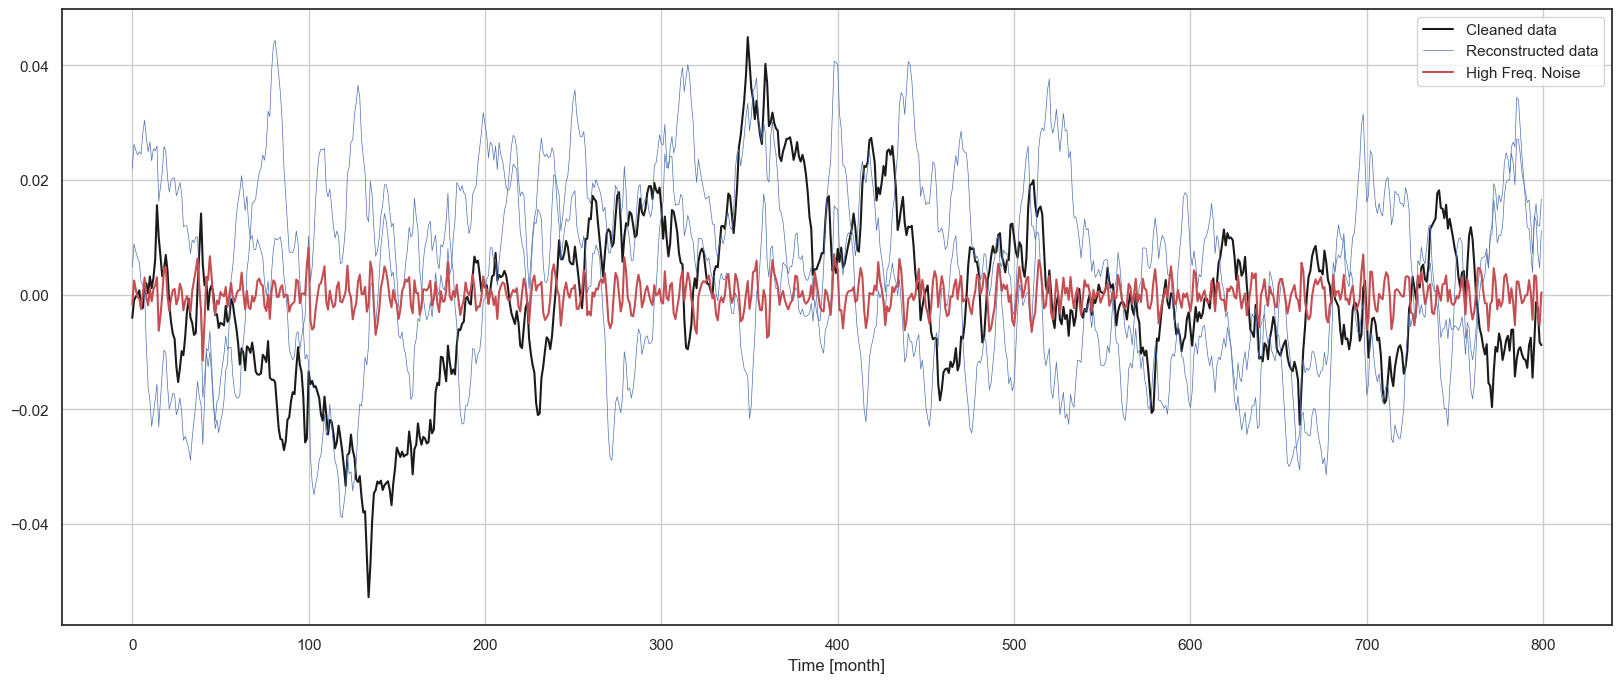

In [42]:
# Plot both the original and filtered signals.

ti = 0
tf = 800
spinuptime = 300 
plt.figure(figsize=(20,8))
plt.plot(t[ti:tf],flux_clean_ts[ti:tf], 'k-',lw=1.5, label='Cleaned data')
#plt.plot(t,flux_clean_filtered_ts, 'g-',lw=2.5, label='Cleaned and Filtered data')
plt.plot(t[ti:tf],flux_reconstr0_ts[ti:tf], 'b-',lw=0.5, label='Reconstructed data')
plt.plot(t[ti:tf],flux_reconstr1_ts[ti:tf], 'b-',lw=0.5)
plt.plot(t[ti:tf],flux_clean_reconstr_noise_ts[:tf], 'r-',lw=1.5, label='High Freq. Noise')

plt.xlabel('Time [month]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

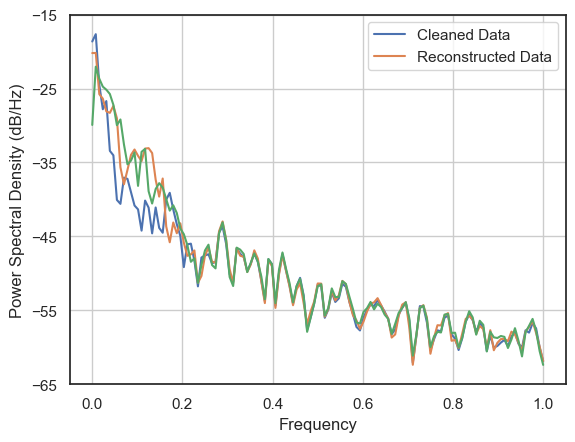

In [48]:
#f, Px = signal.welch(flux_clean_ts,fs=2.0)
#plt.plot(f,10*np.log10(Px))
#plt.psd(flux_clean_ts);

#plt.figure(figsize=(15,6))
#plt.psd(flux_ts,noverlap=120, NFFT=256,label='Original Data');
plt.psd(flux_clean_ts,noverlap=0,NFFT=256,label='Cleaned Data');
#plt.psd(flux_clean_filtered_ts,noverlap=120,NFFT=256,label='Cleaned and Filtered Data');
plt.psd(flux_reconstr0_ts,noverlap=0,NFFT=256,label='Reconstructed Data');
plt.psd(flux_reconstr1_ts,noverlap=0,NFFT=256);
plt.legend();

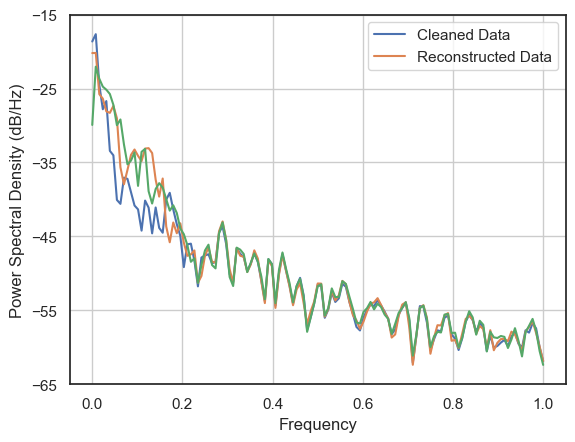

In [49]:
#f, Px = signal.welch(flux_clean_ts,fs=2.0)
#plt.plot(f,10*np.log10(Px))
#plt.psd(flux_clean_ts);

#plt.figure(figsize=(15,6))
#plt.psd(flux_ts,noverlap=120, NFFT=256,label='Original Data');
plt.psd(flux_clean_ts,label='Cleaned Data');
#plt.psd(flux_clean_filtered_ts,noverlap=120,NFFT=256,label='Cleaned and Filtered Data');
plt.psd(flux_reconstr0_ts,label='Reconstructed Data');
plt.psd(flux_reconstr1_ts);
plt.legend();

In [45]:
from scipy import signal
freqs0, psd0 = signal.welch(flux_clean_ts)
freqs1, psd1 = signal.welch(flux_reconstr0_ts)
freqs2, psd2 = signal.welch(flux_reconstr1_ts)

Text(0.5, 0, 'Frequency ($month^{-1}$)')

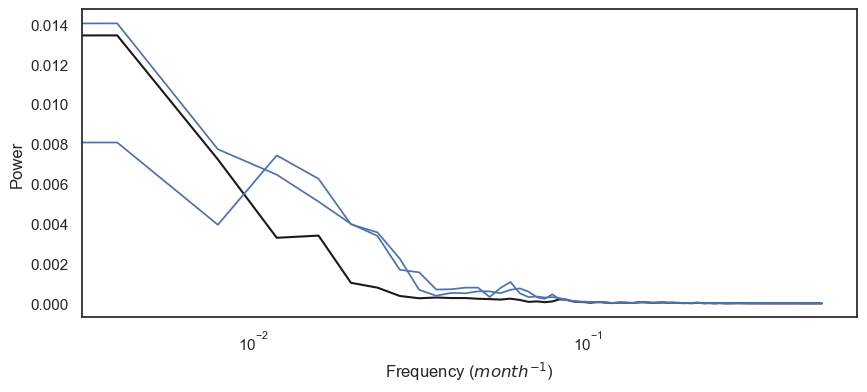

In [46]:
plt.figure(figsize=(10, 4))
plt.semilogx(freqs0, psd0,color='k', linewidth=1.5,label='Original')
plt.semilogx(freqs1, psd1,color='b', linewidth=1.25,label='Randomized')
plt.semilogx(freqs2, psd2,color='b', linewidth=1.25)
plt.ylabel('Power')
plt.xlabel('Frequency ($month^{-1}$)')